<a href="https://colab.research.google.com/github/bickkysahani/timeseries-forecasting/blob/main/timeseries_forecasting_5_weather_prediction_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time series forecasting using arima



In [3]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 35.6 MB/s 
     |████████████████████████████████| 9.8 MB 38.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
import pandas as pd
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read data


In [24]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Weather_data.csv', parse_dates =['datetime (UTC)'])


In [25]:
df.shape

(100057, 13)

In [26]:
df = df.dropna()

In [27]:
df.shape

(100057, 13)

In [28]:
df.head()

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.9


In [29]:
#Lets rename some columns
df = df.rename(columns={'datetime (UTC)':'Date Time',
                                 'coordinates (lat,lon)':'coordinates',
                                  'model (name)':'model',
                                  'model elevation (surface)':'model elevation'
                                  ,'utc_offset (hrs)':'utc',
                                   'temperature (degC)':'Temperature',
                                   'dewpoint_temperature (degC)':'Temperature(dw)',
                                   'wind_speed (m/s)':'Wind Speed',
                                   'mean_sea_level_pressure (Pa)':'Pressure',
                                   'relative_humidity ((0-1))':'Relative Humidity',
                                  'surface_solar_radiation (W/m^2)':'Solar Radiation',
                                  'surface_thermal_radiation (W/m^2)':'Thermal Radiation',
                                  'total_cloud_cover (0-1)':'Total Cloud Cover'
                                  })
#drop some unnecessary columns
df.drop(columns=['coordinates','model','model elevation','utc'], axis=1, inplace=True)

df['Pressure'] = df['Pressure'].apply(lambda x: x*0.01)

In [30]:
df.head()

,Date Time,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation,Total Cloud Cover
0,2010-01-01 00:00:00,18.26,16.39,2.60,1010.4638,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,18.67,16.29,2.91,1010.3796,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,18.16,15.89,3.26,1010.1726,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,18.46,15.33,3.17,1010.2256,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,18.53,15.11,2.95,1009.4003,0.80,459.91,410.00,0.9


In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

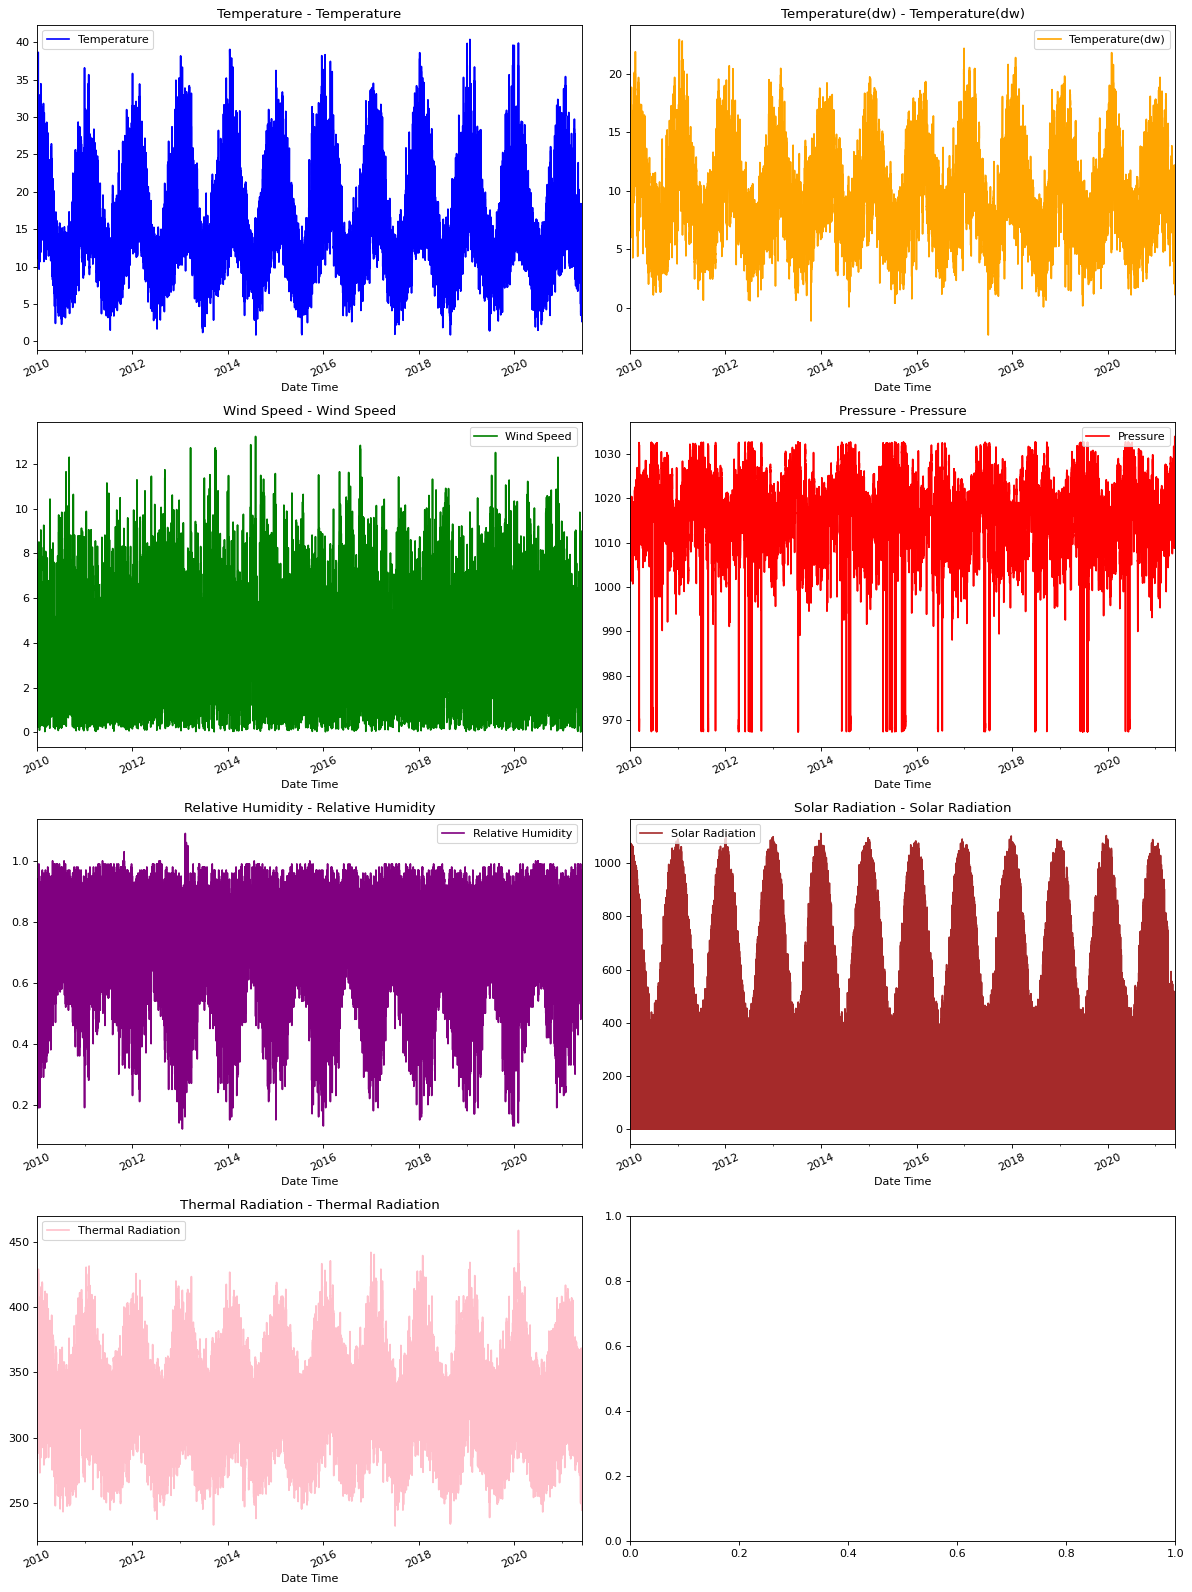

In [36]:
titles = [
    "Temperature",
    "Temperature(dw)",
    "Wind Speed",
    "Pressure",
    "Relative Humidity",
    "Solar Radiation",
    "Thermal Radiation",
    
]

feature_keys = [
   "Temperature",
    "Temperature(dw)",
    "Wind Speed",
    "Pressure",
    "Relative Humidity",
    "Solar Radiation",
    "Thermal Radiation",
    
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)


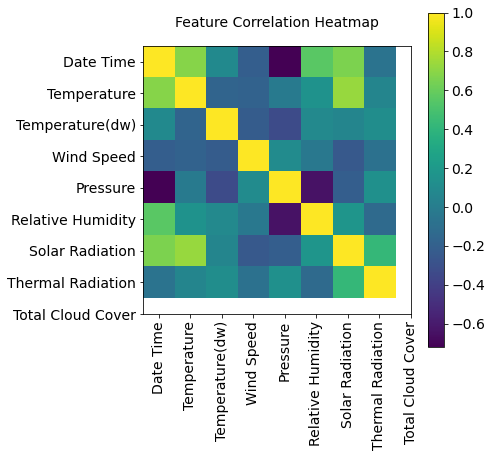

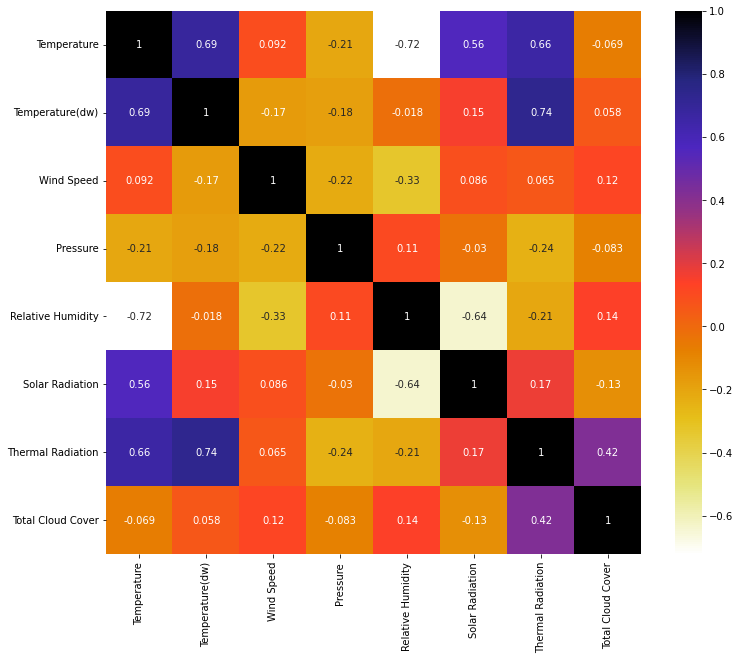

In [37]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    
    plt.title("Feature Correlation Heatmap", fontsize=14)
    import seaborn as sns
  #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    cor =df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
    plt.show()


show_heatmap(df)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100057 entries, 0 to 100056
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date Time          100057 non-null  datetime64[ns]
 1   Temperature        100057 non-null  float64       
 2   Temperature(dw)    100057 non-null  float64       
 3   Wind Speed         100057 non-null  float64       
 4   Pressure           100057 non-null  float64       
 5   Relative Humidity  100057 non-null  float64       
 6   Solar Radiation    100057 non-null  float64       
 7   Thermal Radiation  100057 non-null  float64       
 8   Total Cloud Cover  100057 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 7.6 MB


In [39]:
features_considered = ['Temperature','Temperature(dw)', 'Wind Speed', 'Pressure','Relative Humidity','Solar Radiation','Thermal Radiation','Total Cloud Cover']

In [40]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation,Total Cloud Cover
Date Time,,,,,,,,
2010-01-01 00:00:00,18.26,16.39,2.60,1010.4638,0.89,287.01,408.35,1.0
2010-01-01 01:00:00,18.67,16.29,2.91,1010.3796,0.86,360.79,411.02,1.0
2010-01-01 02:00:00,18.16,15.89,3.26,1010.1726,0.87,291.54,410.67,1.0
2010-01-01 03:00:00,18.46,15.33,3.17,1010.2256,0.82,357.11,410.95,1.0
2010-01-01 04:00:00,18.53,15.11,2.95,1009.4003,0.80,459.91,410.00,0.9


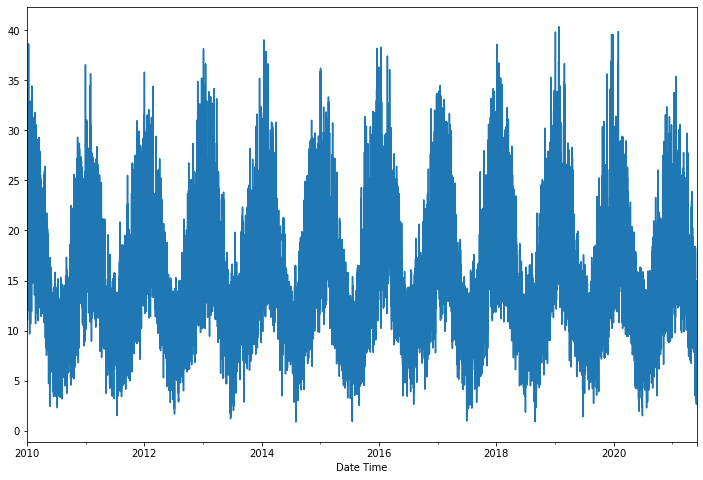

In [42]:
features['Temperature'].plot(figsize=(12,8))

This dataset looks pretty much stationary


Check for Stationarity

In [48]:
#augmented dickey fuller test
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ", dftest[0])
  print("2. P-value : ", dftest[1])
  print("3. Num of lags : ", dftest[2])
  print("4. Numb of Observations Used for ADF Regressions and Critical Values Calculations :",dftest[3])
  print("5. Critical Values : ")
  for key, val in dftest[4].items():
    print("\t",key," : ",val)

In [49]:
ad_test(features['Temperature'])

1. ADF :  -13.297648129081443
2. P-value :  7.152232838571881e-25
3. Num of lags :  66
4. Numb of Observations Used for ADF Regressions and Critical Values Calculations : 99990
5. Critical Values : 
	 1%  :  -3.430415401218969
	 5%  :  -2.861568906314114
	 10%  :  -2.56678538581951



Pretty small P-value indicates that the dataset is stationary


Figuring out the Order for ARIMA Model

AR -> Auto Regressive (Uses previous values to make future predictions)<br>
I  -> Integrated (means differencing) <br>
MA  ->Moving Average (Uses past errors to make future predictions)

In [77]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [78]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)


In [80]:
stepwise_fit =  auto_arima(features['Temperature'], max_p = 2, max_d = 1, max_q = 2, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=254468.562, Time=51.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=291854.647, Time=2.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=270091.540, Time=6.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279653.586, Time=9.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=291852.647, Time=1.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=255454.099, Time=20.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=257004.713, Time=18.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=262036.491, Time=20.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=254466.562, Time=23.64 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=255452.099, Time=10.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=257002.713, Time=9.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=262034.491, Time=8.55 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 181.241 seconds


In [81]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               100057
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -127228.281
Date:                Mon, 29 Nov 2021   AIC                         254466.562
Time:                        09:44:35   BIC                         254514.129
Sample:                             0   HQIC                        254480.997
                             - 100057                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1411      0.011    108.239      0.000       1.120       1.162
ar.L2         -0.4075      0.009    -44.024      0.000      -0.426      -0.389
ma.L1         -0.8664      0.010    -88.360      0.000      -0.886      -0.847
ma.L2          0.5067      0.006     88.617      0.000       0.495       0.518
sigma2         0.7447      0.001    499.546      0.000       0.742       0.748
===================================================================================
Ljung-Box (L1) (Q):                  23.34   Jarque-Bera (JB):            349509.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
#from statsmodels.tsa.arima_model import ARIMA

Split data into training and testing

In [83]:
features.shape

(100057, 8)

In [89]:

train_data = features['2010-01-01':'2020-12-01']
test_data = features['2021-01-01':'2021-12-01']



Train the Model

In [95]:
#train_data['Temperature']

In [98]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data['Temperature'],order=(2,1,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Temperature   No. Observations:                95712
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -122719.281
Date:                Mon, 29 Nov 2021   AIC                         245448.561
Time:                        09:55:56   BIC                         245495.907
Sample:                    01-01-2010   HQIC                        245462.958
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1233      0.011    104.631      0.000       1.102       1.144
ar.L2         -0.3968      0.009    -42.040      0.000      -0.415      -0.378
ma.L1         -0.8613      0.010    -86.848      0.000      -0.881      -0.842
ma.L2          0.5113      0.006     86.768      0.000       0.500       0.523
sigma2         0.7607      0.002    484.329      0.000       0.758       0.764
===================================================================================
Ljung-Box (L1) (Q):                  19.24   Jarque-Bera (JB):            327216.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Make Predictions on Test Data

In [104]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
prediction = model.predict(start=start,end=end,type='levels')
#prediction.index = features.index[start:end+1]
print(prediction)

2020-12-02 00:00:00    15.409835
2020-12-02 01:00:00    15.836573
2020-12-02 02:00:00    16.022355
2020-12-02 03:00:00    16.061708
2020-12-02 04:00:00    16.032192
                         ...    
2021-05-01 20:00:00    15.896688
2021-05-01 21:00:00    15.896688
2021-05-01 22:00:00    15.896688
2021-05-01 23:00:00    15.896688
2021-05-02 00:00:00    15.896688
Freq: H, Name: predicted_mean, Length: 3625, dtype: float64


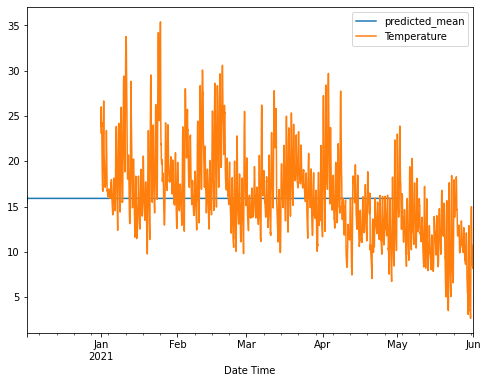

In [108]:
prediction.plot(legend = True)
test_data['Temperature'].plot(legend=True)

In [107]:
test_data['Temperature'].mean()

16.20904827586208

In [110]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(prediction,test_data['Temperature']))
print(rmse)

4.916575849417479


Retrain the model on the entire dataset this time

In [111]:
model2 = ARIMA(features['Temperature'],order=(2,1,2))
model2 = model2.fit()


In [112]:
features.tail()

,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation,Total Cloud Cover
Date Time,,,,,,,,
2021-05-31 20:00:00,8.31,3.28,4.91,1020.3373,0.71,0.00,278.11,0.93
2021-05-31 21:00:00,8.15,3.16,4.63,1020.3349,0.71,0.00,277.98,1.00
2021-05-31 22:00:00,8.72,3.31,5.29,1020.6984,0.69,8.99,281.65,1.00
2021-05-31 23:00:00,9.83,3.88,5.60,1020.7712,0.66,80.46,296.20,1.00
2021-06-01 00:00:00,10.73,4.25,5.43,1021.0962,0.64,149.84,305.43,0.99


For future dates

In [124]:
pred = model2.predict(start=len(features),end = len(features)+24,type="levels").rename('ARIMA Predictions')

In [125]:
print(pred)

2021-06-01 01:00:00    11.486516
2021-06-01 02:00:00    12.165459
2021-06-01 03:00:00    12.631920
2021-06-01 04:00:00    12.887526
2021-06-01 05:00:00    12.989111
2021-06-01 06:00:00    13.000866
2021-06-01 07:00:00    12.972883
2021-06-01 08:00:00    12.936160
2021-06-01 09:00:00    12.905659
2021-06-01 10:00:00    12.885818
2021-06-01 11:00:00    12.875607
2021-06-01 12:00:00    12.872041
2021-06-01 13:00:00    12.872133
2021-06-01 14:00:00    12.873691
2021-06-01 15:00:00    12.875431
2021-06-01 16:00:00    12.876783
2021-06-01 17:00:00    12.877615
2021-06-01 18:00:00    12.878014
2021-06-01 19:00:00    12.878131
2021-06-01 20:00:00    12.878101
2021-06-01 21:00:00    12.878020
2021-06-01 22:00:00    12.877939
2021-06-01 23:00:00    12.877880
2021-06-02 00:00:00    12.877845
2021-06-02 01:00:00    12.877830
Freq: H, Name: ARIMA Predictions, dtype: float64


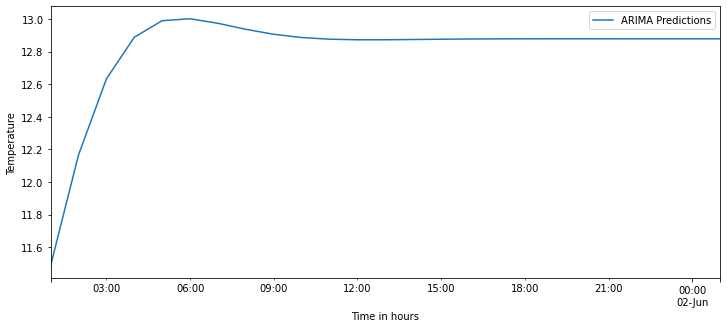

In [128]:
pred.plot(figsize=(12,5),legend = True,ylabel='Temperature',xlabel='Time in hours')
